In [1]:
from math import pi, pow
import numpy as np
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import *
from qiskit.circuit.library import *
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.simulator.snapshot import snapshot
from scipy import optimize
from matplotlib.pyplot import plot,show
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

In [2]:
# Circuit quantique

def get_z_gates(n):
    q = QuantumRegister(n, name="x")
    aux = QuantumCircuit(q)
    for i in range(n):
        if(i == n-1):
            aux.x(q[i])
        else:
            c = [j for j in range(i+1,n)]
            aux.mcx(c, i, mode="noancilla")
    z_up = aux.to_gate(label="Z+")
    z_down = aux.inverse().to_gate(label="Z-")
    return z_up, z_down

def step(qc, pos, coin, n, z_up, z_down):
    qc.h(coin[0])
    # Z+
    t1 = [coin[0]]
    t2 = [pos[i] for i in range(n)]
    t3 = t1 + t2
    qc.append(z_up.control(), t3)
    # NOT GATE
    qc.x(coin[0])
    # Z-
    qc.append(z_down.control(), t3)
    # NOT GATE
    qc.x(coin[0])
    
def circuit(n, n_step):
    # registre pour la position
    pos = QuantumRegister(n, name="pos")
    # registre pour le coin operator
    coin = QuantumRegister(1, name="coin")
    # registre pour la mesure
    c = ClassicalRegister(n, name="y")

    qc = QuantumCircuit(pos, coin, c)
    # construction des portes Z+ et Z-
    z_up, z_down = get_z_gates(n)

    for i in range(n_step):
        step(qc, pos, coin, n, z_up, z_down)
        
    # on mesure seulement le registre de la position
    qc.measure(pos,c)
    return qc

In [3]:
# QW

def mat(n, s):
    power = int(pow(2, n))
    m = np.zeros((power, power))
    for i in range(power):
        m[(i + 2*s -1) % power][i] = 1
    return m

'''
Renvoi un tableau de couples (i,j) avec i la position et j sa probabilité
'''
def decode(psi, n):
    res = []
    for i in range(len(psi)):
        if psi[i] != 0:
            m = int(i % pow(2,n))
            binary = format(m, "b").zfill(n)
            if binary not in res:
                res.append((binary, abs(psi[i][0])**2))
    return res

def quantum_walk(n, n_step, coin, psi):
    m1 = mat(n, 0)
    m2 = mat(n, 1)

    m1 = np.kron([[1,0],[0,0]], m1)
    m2 = np.kron([[0,0],[0,1]], m2)

    s = m1 + m2
    u = np.kron(coin, np.identity(int(pow(2,n))))
    q = np.matmul(s, u)
    f = np.linalg.matrix_power(q, n_step)
    psi = np.matmul(f, psi)
    return psi

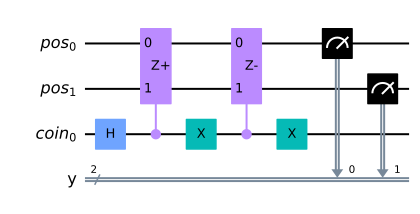

In [4]:
# nombre de noeuds du cercle (nombre de qubits)
n = 2
# nombre de steps
n_step = 1

# qw
coin = np.array([[1/np.sqrt(2),1/np.sqrt(2)], [1/np.sqrt(2),-1/np.sqrt(2)]])
# initialisation de psi
psi = np.zeros((int(pow(2,n+1)),1))
psi[0][0] = 1
psi = quantum_walk(n, n_step, coin, psi)

# circuit
circ = circuit(n, n_step)
circ.draw("mpl")

{'11': 525, '01': 499}


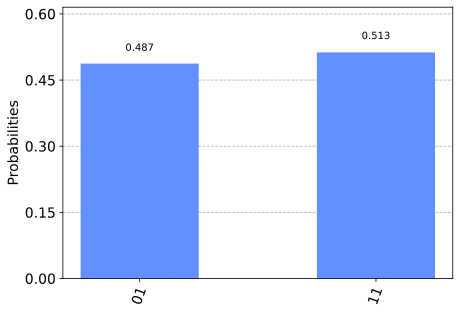

In [8]:
# résultats des mesures du circuit
backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=1024)
counts = dict(job.result().get_counts(circ))
# pour remettre les indices dans le bon ordre
d = {}
for i in counts.keys():
    d[i[::-1]] = counts[i]

print(d)
plot_histogram(d)

In [6]:
# résultats de la QW
res = decode(psi, n)
res

[('11', 0.4999999999999999), ('01', 0.4999999999999999)]